In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

import math

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

from RW_NN import IQ_gen_NN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           241       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)         (None, 126)               0         
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-trai

## pyvista visualization

In [2]:
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

#### Wave vector distribution ####
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def std_phi(kappa):
    xi_list = np.linspace(1/10000,1,10000)
    W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
    phi = np.arccos(W)
    sigma = np.sqrt(np.sum(phi**2*np.sin(phi))/np.sum(np.sin(phi)))/np.pi*180
    return sigma

In [3]:
def clip_random_wave(fp_opt, T=100):
    ### Clipping random wave ####
    k_mean = np.array([0,0,20])*np.pi
    k_var  = (np.array([0,0,fp_opt['sigma_k']])*np.pi)**2 # k_z
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean/2,k_cov/2,n_wave = 60, kappa = fp_opt['kappa']) # kappa

    alpha = fp_opt['alpha'] # alpha

    ### pyvista ###
    import pyvista as pv
    pv.set_jupyter_backend('trame')
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho.flatten('F')
    mesh = grid.contour([alpha])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    backface_params = dict(color='#303030',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
    #                        opacity=0.5
                        )
    pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
    #             opacity=0.5
                )

    # camera setting
    pl.camera_position = 'yz'
    pl.camera.azimuth = -60.0
    pl.camera.elevation = 24.0
    pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    path = '../Figures/'
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print('new directory created')

    filename = path+'PSPDMS_{:0.0f}_{:0.4f}-{:0.4f}-{:0.4f}.png'.format(T,fp_opt['sigma_k'],fp_opt['kappa'],fp_opt['alpha'])
    pl.show(screenshot=filename)

## load experimental data

In [4]:
import os
filename = '../data/PSPDMS_LAM_SAXS.csv'
data = np.loadtxt(filename, skiprows=1, delimiter=',')
Q = data[:,0]
IQ_T = data[:,1:]

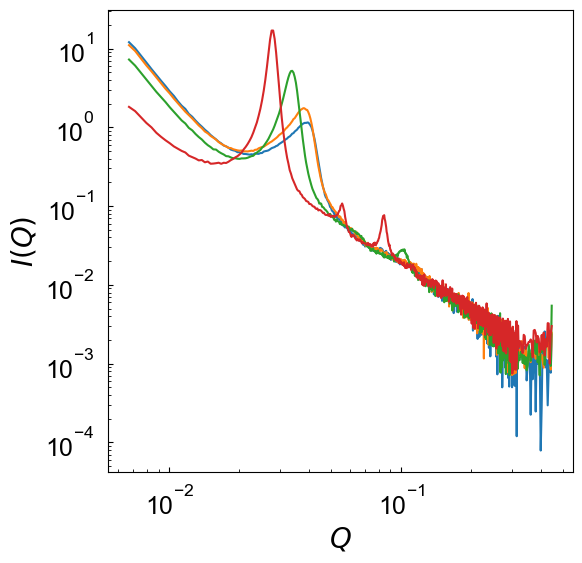

In [5]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
T_list = [30,60,80,100]
for i_T, T in enumerate(T_list):
    IQ = IQ_T[:,i_T]
    ax.plot(Q, IQ, label=data[0])

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

0.03937
0.03811
0.03392
0.02806


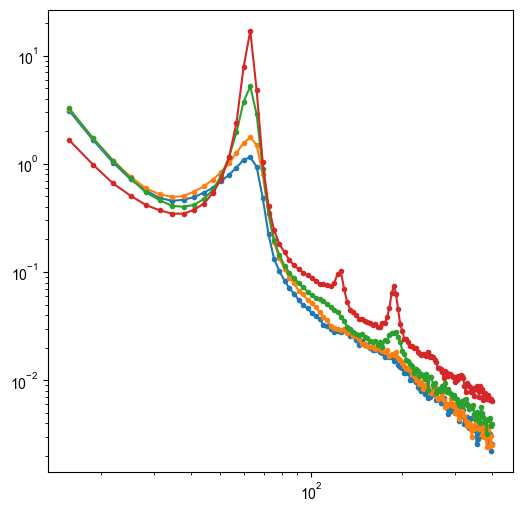

In [6]:
IQ_list = []
Q_err_list = []

box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i_T, T in enumerate(T_list):
    IQ = IQ_T[:,i_T]

    # ## trim low Q
    # index_Q = Q_in>7e-3
    # Q = Q_in[index_Q]
    # IQ = IQ_in[index_Q]
    # IQ_err = IQ_err_in[index_Q]

    # ## extend low Q
    # index_low_Q = Q<3.5e-2
    # Q_low_Q = Q[index_low_Q]
    # IQ_low_Q = IQ[index_low_Q]
    # coeff = np.polyfit(Q_low_Q, IQ_low_Q, 2)
    # p = np.poly1d(coeff)
    # IQ[index_low_Q] = p(Q_low_Q)

    # ## substrate background
    # index_high_Q = Q>2e-1
    # IQ_high_Q = IQ[index_high_Q]
    # I_bg = np.mean(IQ_high_Q)
    # IQ = IQ - I_bg

    # ## substrate low-Q
    # A_4 = IQ[0]/Q[0]**(-4)
    # IQ_4 = A_4*Q**(-4)
    # IQ = IQ - IQ_4*0

    # ## extend high Q
    # index_high_Q = (Q>2e-1)
    # index_high_Q_fit = (Q>2e-1)*(Q<3e-1)
    # Q_high_Q = Q[index_high_Q_fit]
    # IQ_high_Q = IQ[index_high_Q_fit]
    # coeff = np.polyfit(Q_high_Q, np.log(IQ_high_Q), 2)
    # p = np.poly1d(coeff)
    # IQ[index_high_Q] = np.exp(p(Q[index_high_Q]))

    ## peak_position
    index_peak_range = Q>1.5e-2
    Q_peak_range = Q[index_peak_range]
    IQ_peak_range = IQ[index_peak_range]

    index_Q_max = np.argmax(IQ_peak_range)
    Q_max = Q_peak_range[index_Q_max]
    print(Q_max)
    Q_rs = Q/Q_max*np.pi*20
    f_interp = interp.interp1d(Q_rs, IQ, kind='linear',fill_value='extrapolate')
    IQ_interp = f_interp(qq)
    IQ_interp[IQ_interp<0] = 1e-6

    IQ_list.append(IQ_interp)

    # ## interpolate resolution
    # f_interp = interp.interp1d(Q_rs, Q_err_in, kind='linear',fill_value='extrapolate')
    # Q_err_interp = f_interp(qq)/Q_max*np.pi*20
    # Q_err_list.append(Q_err_interp)

    ax.plot(qq[5:], IQ_interp[5:], '.-', label=data[0])
    # ax.plot(qq[5:], Q_err_interp[5:], '.-', label=data[0])
    # ax.plot(Q_high_Q, IQ[index_high_Q], '.', label=data[0])
    # ax.plot(Q,IQ)

IQ_list = np.array(IQ_list)
Q_err_list = np.array(Q_err_list)

# ax.set_ylim([1e-1,1e2])

ax.set_yscale('log')
ax.set_xscale('log')

## Fit the data

In [7]:
def IQ_th(Q, params):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    IQ_NN = IQ_gen_NN(fp)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, np.log(IQ_NN), kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']

def lmbda(params, Q, data, index_Q):
    IQ_model = IQ_th(Q, params)
    residue = (np.log(data) - np.log(IQ_model))[index_Q]/np.exp(Q[index_Q])
    return residue

### 100 C

In [8]:
# fitting targets
index_data = 3
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]>60)*(qq[1:-1]<200)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [0.12, 12.19, 0.17, 4e5, 1]
lb =  [0,    8,     0,    1e5, 0.9]
ub =  [0.15, 20,    0.3,  5e5, 1.1]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('nedler')

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 533
    # data points      = 44
    # variables        = 5
    chi-square         = 8.3872e-59
    reduced chi-square = 2.1506e-60
    Akaike info crit   = -6040.43991
    Bayesian info crit = -6031.51896
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.01770307 (init = 0.12)
    kappa:    10.9854850 (init = 12.19)
    alpha:    0.16754241 (init = 0.17)
    y_scale:  362116.551 (init = 400000)
    x_scale:  0.99556575 (init = 1)


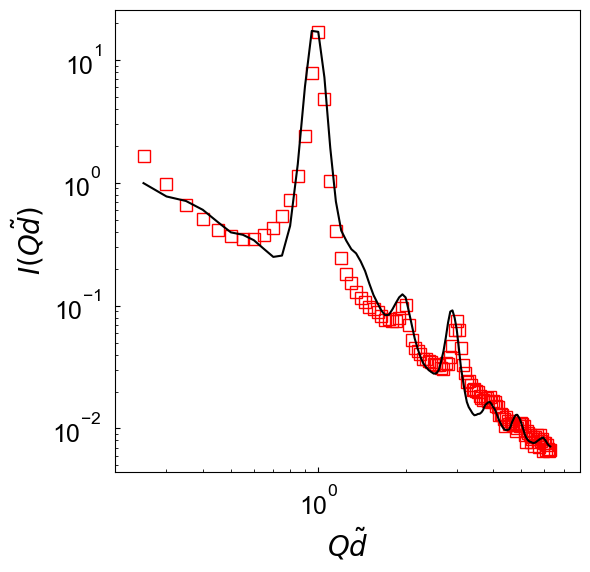

In [9]:
## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
# ax.plot(Q/0.02806,IQ_T[:,3],'sr',fillstyle='none')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot]+0.004,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [10]:
fp_opt = result.params.valuesdict()
clip_random_wave(fp_opt, T=100)

Widget(value="<iframe src='http://localhost:53823/index.html?ui=P_0x270a9ac1f10_0&reconnect=auto' style='width…

### 80 C

In [11]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]>60)*(qq[1:-1]<400)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [0.5, 5,     0.1, 1e5, 1.05]
lb =  [0,   1,     0,   5e4, 0.8]
ub =  [1,   9,    0.2,  5e5, 1.2]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('nedler')

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 351
    # data points      = 107
    # variables        = 5
    chi-square         = 5.3011e-63
    reduced chi-square = 5.1971e-65
    Akaike info crit   = -15833.2521
    Bayesian info crit = -15819.8880
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.50292778 (init = 0.5)
    kappa:    5.01989414 (init = 5)
    alpha:    0.09984627 (init = 0.1)
    y_scale:  134409.266 (init = 100000)
    x_scale:  1.00852317 (init = 1.05)


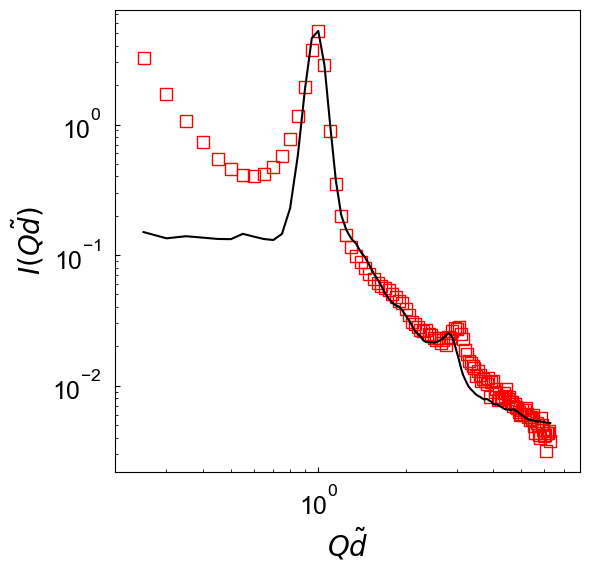

In [12]:
## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
# ax.plot(Q/0.02806,IQ_T[:,3],'sr',fillstyle='none')
# ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit]+0.004,'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot]+0.004,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [13]:
fp_opt = result.params.valuesdict()
clip_random_wave(fp_opt, T=80)

Widget(value="<iframe src='http://localhost:53823/index.html?ui=P_0x272656ac190_1&reconnect=auto' style='width…

### 60C

In [14]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]>40)*(qq[1:-1]<400)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [2.5,   2,   0.1, 1e5, 1.05]
lb =  [0,   0,     0,   5e4, 0.8]
ub =  [6,   5,    0.2,  5e5, 1.2]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('powell')

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 67
    # data points      = 114
    # variables        = 5
    chi-square         = 2.9397e-40
    reduced chi-square = 2.6970e-42
    Akaike info crit   = -10906.7865
    Bayesian info crit = -10893.1056
##  Warning: uncertainties could not be estimated:
    x_scale:  at initial value
[[Variables]]
    sigma_k:  3.33316212 (init = 2.5)
    kappa:    1.94440179 (init = 2)
    alpha:    0.09944558 (init = 0.1)
    y_scale:  99863.7664 (init = 100000)
    x_scale:  1.04999375 (init = 1.05)


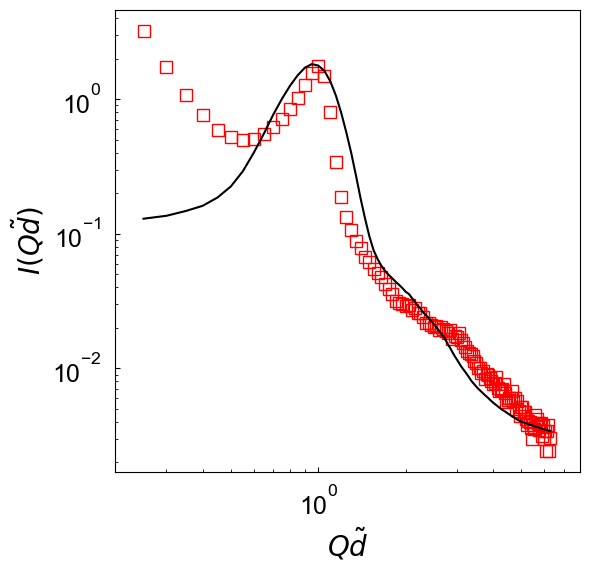

In [15]:
## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
# ax.plot(Q/0.02806,IQ_T[:,3],'sr',fillstyle='none')
# ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit]+0.0025,'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot]+0.0025,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [16]:
fp_opt = result.params.valuesdict()
clip_random_wave(fp_opt, T=60)

Widget(value="<iframe src='http://localhost:53823/index.html?ui=P_0x272db87cbe0_2&reconnect=auto' style='width…

### 30C

In [17]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]>30)*(qq[1:-1]<400)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [4,   1,   0.15, 7e4, 1.05]
lb =  [0,   0,     0,   5e4, 0.9]
ub =  [6,   5,    0.4,  1e5, 1.1]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('nedler')

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 322
    # data points      = 117
    # variables        = 5
    chi-square         = 5.2976e-32
    reduced chi-square = 4.7300e-34
    Akaike info crit   = -8972.98418
    Bayesian info crit = -8959.17331
[[Variables]]
    sigma_k:  4.51650755 +/- 0.00902505 (0.20%) (init = 4)
    kappa:    0.88065554 +/- 0.00395983 (0.45%) (init = 1)
    alpha:    0.15084345 +/- 4.9491e-04 (0.33%) (init = 0.15)
    y_scale:  70241.3174 +/- 3949.99804 (5.62%) (init = 70000)
    x_scale:  1.03247505 +/- 0.02813550 (2.73%) (init = 1.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(y_scale, x_scale) = +0.9997
    C(sigma_k, kappa)   = -0.7354
    C(sigma_k, alpha)   = +0.3904
    C(kappa, alpha)     = -0.3788


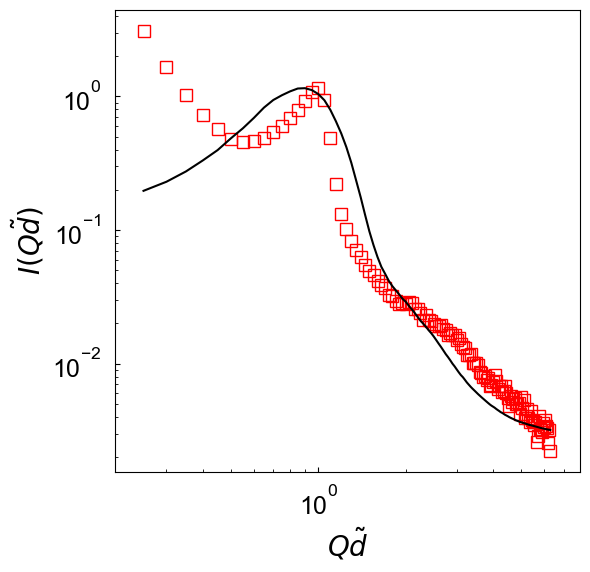

In [18]:
## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
# ax.plot(Q/0.02806,IQ_T[:,3],'sr',fillstyle='none')
# ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit]+0.0025,'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot]+0.0025,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [19]:
fp_opt = result.params.valuesdict()
clip_random_wave(fp_opt, T=30)

Widget(value="<iframe src='http://localhost:53823/index.html?ui=P_0x272f2edd2b0_3&reconnect=auto' style='width…